In [65]:
import numpy as np
import torch
from torch import nn
import torch.autograd.functional as Fu
from functorch import vmap, hessian, jacfwd
STATELEN = 5
ACTLEN = 3
STEP_SIZE = 4
#based on https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf
class Dynamics(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Dynamics, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size),
        )
        self.freeze = 0
        # we have to freeze at estimate because we have to use vmap for batch training
    def forward(self, input_element):
        output = self.linear_relu_stack(input_element)
        return output
    
class reward(nn.Module):
    #NAF
    def __init__(self, input_size, hidden_size, output_size):
        super(reward, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size),
        )
    def forward(self, input_element):
        output = self.linear_relu_stack(input_element)
        return output

class policy(nn.Module):
    #global
    def __init__(self, input_size, hidden_size, output_size):
        super(reward, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size),
        )
    def forward(self, input_element):
        output = self.linear_relu_stack(input_element)
        return output
    
    #torch.distributions.multivariate_normal.MultivariateNormal
    #MultivariateNormal(torch.zeros(2), torch.eye(2)) #psd
class ilqr:
    
    def __init__(self, ts, dyn, re, sl, al, b_s):
        """
        Args:
            ts: time step
            dyn: dynamic
            re: reward
            sl: state length
            al: action length
        """
        self.ts = ts
        self.dyn = dyn
        self.re = re
        self.sl = sl
        self.al = al
        self.b_s = b_s
        
        self.S = torch.zeros((self.ts, self.b_s, self.sl))
        self.A = torch.zeros((self.ts, self.b_s, self.al))
        self.R = torch.empty((self.ts, self.b_s, 1))
        self.K_arr = torch.zeros(self.ts, self.b_s, self.al, self.sl)
        self.k_arr = torch.zeros(self.ts, self.b_s, 1, self.al)
        self.ifconv = 0
        

    def _get_batch_reward(self, state_action):
        
        state, action = torch.split(state_action, [self.sl, self.al], dim=-1)
        pre_psd, bias, value = torch.split(self.re(state), [self.al**2, self.al, 1], dim=-1)
        
        pre_psd = torch.reshape(pre_psd, (self.b_s, self.al, self.al))
        pre_psd_trans = torch.transpose(pre_psd, 1, 2)
        psd = torch.matmul(pre_psd, pre_psd_trans)
        
        a_b = (action - bias).unsqueeze(1)
        a_b_t = torch.transpose(a_b,1,2)
        return value - torch.matmul(torch.matmul(a_b,psd),a_b_t).squeeze(-1)
        
    def _get_reward(self, state_action):
        
        state, action = torch.split(state_action, [self.sl, self.al], dim=-1)
        pre_psd, bias, value = torch.split(self.re(state), [self.al**2, self.al, 1], dim=-1)
        
        pre_psd = torch.reshape(pre_psd, (self.al, self.al))
        pre_psd_trans = torch.transpose(pre_psd, 0, 1)
        psd = torch.matmul(pre_psd, pre_psd_trans)
        
        a_b = (action - bias).unsqueeze(1)
        a_b_t = torch.transpose(a_b,0,1)
        return value.squeeze() - torch.matmul(torch.matmul(a_b_t,psd),a_b).squeeze()
    
    def _forward(self):
        
        new_S = torch.zeros((self.ts, self.b_s, self.sl))
        new_A = torch.zeros((self.ts, self.b_s, self.al))
        s = self.S[0].clone().detach()
        #for p in self.dyn.parameters():
        #    print(p)
        i = 0
        while i < self.ts:
            new_S[i] = s
            state_difference = (new_S[i] - self.S[i]).unsqueeze(1)
            
            state_action_trans = torch.matmul(state_difference,torch.transpose((self.K_arr[i]),1,2))
            
            new_A[i] = (state_action_trans + self.k_arr[i]).squeeze(1) + self.A[i]
            sa_in = torch.cat((new_S[i], new_A[i]),dim = 1)
            
            s = self.dyn(sa_in)

            #state shape = [1,state_size]

            self.R[i] = self._get_batch_reward(sa_in)
            
            i = i + 1
        self.S = new_S
        self.A = new_A

    def _backward(self):
        
        C = torch.zeros(self.b_s, self.al + self.sl, self.al + self.sl)
        F = torch.zeros(self.b_s, self.sl, self.al + self.sl)
        c = torch.zeros(self.b_s, 1, self.al + self.sl)
        V = torch.zeros(self.b_s, self.sl, self.sl)
        v = torch.zeros(self.b_s, 1, self.sl)
        sa_in = torch.cat((self.S, self.A),dim = -1)
        
        i = self.ts -1
        while i > -1:

            C = vmap(hessian(self._get_reward))(sa_in[i])
            #shape = [state+action, state+action]
            #print(torch.sum(C[j]))
            c = vmap(jacfwd(self._get_reward))(sa_in[i])
            
            #shape = [1, state+action]
            #print(torch.sum(c[j]))
            F = vmap(jacfwd(self.dyn))(sa_in[i])
            #shape = [state, state+action]
            #print(torch.sum(F[j]))
            # use jacfwd because input is large than output
            transF = torch.transpose(F,1,2)
            Q = C + torch.matmul(torch.matmul(transF, V), F)

            #eq 5[c~e]
            q = c.unsqueeze(1) + torch.matmul(v, F)

            #eq 5[a~b]
            
            Q_pre1, Q_pre2 = torch.split(Q, [self.sl, self.al], dim = 1)
            Q_xx, Q_xu = torch.split(Q_pre1, [self.sl, self.al], dim = 2)
            Q_ux, Q_uu = torch.split(Q_pre2, [self.sl, self.al], dim = 2)
            
            Q_x, Q_u = torch.split(q, [self.sl, self.al], dim = -1)
            ## how to batched eye?
            #print(Q_uu)
            try:
                invQuu = torch.linalg.inv(Q_uu - torch.eye(self.al)*0.01)# - torch.eye(self.al)) #regularize term
                #eq [9]
            except:
                invQuu = torch.linalg.inv(Q_uu + torch.eye(self.al)*0.01)
                self.ifconv = 1

            K = -torch.matmul(invQuu, Q_ux)
            transK = torch.transpose(K, 1, 2)
            #K_t shape = [actlen, statelen]

            k = -torch.matmul(Q_u, invQuu)
            #k_t shape = [1,actlen]

            V = (Q_xx + torch.matmul(Q_xu, K) + 
                 torch.matmul(transK, Q_ux) +
                 torch.matmul(torch.matmul(transK, Q_uu), K)
                )
            # eq 11c
            #V_t shape = [statelen, statelen]

            v = (Q_x + torch.matmul(k, Q_ux) + 
                 torch.matmul(Q_u, K) + 
                 torch.matmul(k, torch.matmul(Q_uu, K)) 
                )
            # eq 11b
            #v_t shape = [1, statelen]
            
            self.K_arr[i] = K
            self.k_arr[i] = k
            i = i - 1
    
    def fit(self, action, state):
        self.A = action
        self.S[0] = state[0]
        setattr(self.dyn,'freeze',1)
        i = 0
        while (self.ifconv != 1) and i < 100:
            i = i + 1
            self._forward()
            self._backward()

            print("act",self.A)
        return self.A

# for param in rew.parameters():
#    print(param)

In [66]:
my_Dyna = Dynamics(STATELEN + ACTLEN, STATELEN, STATELEN)
my_reward = reward(STATELEN, STATELEN , ACTLEN**2 + ACTLEN + 1)
TIME_STEP = 6
BATCH_SIZE = 5
myilqr = ilqr(TIME_STEP, my_Dyna, my_reward, STATELEN, ACTLEN, BATCH_SIZE)
action = torch.rand((TIME_STEP, BATCH_SIZE, ACTLEN))
state = torch.zeros((TIME_STEP, BATCH_SIZE, STATELEN))
#simulate
#fit reward, dynamic
myilqr.fit(action, state)

act tensor([[[0.2277, 0.0591, 0.4367],
         [0.2343, 0.0996, 0.5524],
         [0.6383, 0.5095, 0.2959],
         [0.9270, 0.1393, 0.2315],
         [0.2984, 0.8681, 0.5585]],

        [[0.1134, 0.5634, 0.9828],
         [0.5259, 0.5961, 0.5791],
         [0.9666, 0.1994, 0.2510],
         [0.8835, 0.1216, 0.4629],
         [0.0057, 0.6606, 0.3636]],

        [[0.3954, 0.4540, 0.9163],
         [0.5561, 0.0212, 0.5205],
         [0.4214, 0.3996, 0.4864],
         [0.5211, 0.3082, 0.6915],
         [0.2225, 0.4429, 0.8786]],

        [[0.1925, 0.8807, 0.0220],
         [0.3093, 0.9303, 0.1509],
         [0.1140, 0.2144, 0.6088],
         [0.8726, 0.6869, 0.5256],
         [0.0149, 0.3884, 0.9895]],

        [[0.5366, 0.7609, 0.3623],
         [0.1822, 0.7380, 0.1089],
         [0.3387, 0.1850, 0.9478],
         [0.0949, 0.3342, 0.2674],
         [0.8427, 0.2960, 0.9518]],

        [[0.6852, 0.1004, 0.2906],
         [0.0518, 0.4252, 0.0247],
         [0.3832, 0.3733, 0.0714],
      

act tensor([[[ 0.8281, -0.0352,  0.8009],
         [ 0.8379, -0.0430,  0.8235],
         [ 0.8417, -0.0461,  0.8324],
         [ 0.8415, -0.0459,  0.8318],
         [ 0.7580,  0.0208,  0.6388]],

        [[ 1.0316, -0.3112,  1.1841],
         [ 1.0235, -0.3031,  1.1652],
         [ 1.0186, -0.2981,  1.1537],
         [ 1.0248, -0.3042,  1.1680],
         [ 1.0368, -0.3185,  1.1990]],

        [[ 1.0003, -0.2776,  1.1009],
         [ 1.0054, -0.2827,  1.1129],
         [ 1.0124, -0.2897,  1.1290],
         [ 1.0047, -0.2820,  1.1111],
         [ 0.9956, -0.2726,  1.0895]],

        [[ 0.9741, -0.2520,  1.0431],
         [ 0.9802, -0.2578,  1.0567],
         [ 0.9819, -0.2592,  1.0602],
         [ 0.9971, -0.2744,  1.0954],
         [ 0.9939, -0.2716,  1.0886]],

        [[ 1.0798, -0.3599,  1.2873],
         [ 1.0759, -0.3560,  1.2782],
         [ 1.0855, -0.3652,  1.2999],
         [ 1.0665, -0.3462,  1.2558],
         [ 1.0806, -0.3601,  1.2882]],

        [[ 0.3341,  0.3925, -0.4336]

act tensor([[[ 0.8452, -0.0488,  0.8403],
         [ 0.8454, -0.0490,  0.8409],
         [ 0.8455, -0.0491,  0.8412],
         [ 0.8455, -0.0491,  0.8411],
         [ 0.8434, -0.0474,  0.8361]],

        [[ 1.0297, -0.3089,  1.1790],
         [ 1.0294, -0.3086,  1.1784],
         [ 1.0293, -0.3085,  1.1781],
         [ 1.0295, -0.3086,  1.1785],
         [ 1.0303, -0.3095,  1.1805]],

        [[ 1.0126, -0.2896,  1.1291],
         [ 1.0128, -0.2898,  1.1294],
         [ 1.0129, -0.2900,  1.1299],
         [ 1.0127, -0.2897,  1.1292],
         [ 1.0123, -0.2893,  1.1283]],

        [[ 0.9962, -0.2732,  1.0930],
         [ 0.9963, -0.2733,  1.0932],
         [ 0.9962, -0.2733,  1.0931],
         [ 0.9967, -0.2738,  1.0942],
         [ 0.9967, -0.2738,  1.0942]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0865, -0.3658,  1.3017],
         [ 1.0867, -0.3660,  1.3020],
         [ 1.0863, -0.3656,  1.3012],
         [ 1.0865, -0.3658,  1.3015]],

        [[ 0.3108,  0.4154, -0.4868]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8455, -0.0491,  0.8412]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1787]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2737,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3092,  0.4169, -0.4904]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4170, -0.4906]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2737,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2737,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4171, -0.4907]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2737,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4171, -0.4907]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4171, -0.4907]

act tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4171, -0.4907]

tensor([[[ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413],
         [ 0.8456, -0.0491,  0.8413]],

        [[ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786],
         [ 1.0295, -0.3087,  1.1786]],

        [[ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296],
         [ 1.0128, -0.2898,  1.1296]],

        [[ 0.9966, -0.2737,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2736,  1.0939],
         [ 0.9966, -0.2737,  1.0939]],

        [[ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018],
         [ 1.0866, -0.3659,  1.3018]],

        [[ 0.3091,  0.4171, -0.4907],
  

In [15]:
#F.hessian(my_reward, torch.rand((STATELEN+ACTLEN))
#         )

In [19]:
import torch
S = torch.rand((4))
print(S[-1])

tensor(0.8921)


In [4]:
import numpy as np
np.shape(S.view(-1))

torch.Size([12])

In [9]:
np.shape(S.squeeze())

torch.Size([3, 4])

In [11]:
new_S = torch.rand((4, 1, 3))
new_A = torch.rand((4, 1, 5))

my_Dyna = Dynamics(STATELEN + ACTLEN, STATELEN, STATELEN)
my_reward = reward(STATELEN + ACTLEN, STATELEN , 1)

s = S[0].clone().detach()


i = 0
while i < self.ts:
    new_S[i] = s
    new_A[i] = (torch.matmul(new_S[i] - S[i],torch.transpose((K_arr[i]),0,1)) + 
         k_arr[i] + A[i]
        )
    sa_in = torch.cat((new_S[i], new_A[i]),dim = 1)
    #sa_in shape = [1,state_size + action_size]

    s = my_Dyna(sa_in)
    #state shape = [1,state_size]

    R[i] = my_reward(sa_in)

    i = i + 1

NameError: name 'self' is not defined

In [27]:
new_S = torch.rand((4, 2, 3))
new_A = torch.rand((4, 2, 5))
print(new_S)
print(new_A)
sa_in = torch.cat((new_S[0], new_A[0]),dim = 1)
print(np.shape(sa_in))

tensor([[[0.2503, 0.3700, 0.4463],
         [0.4160, 0.0699, 0.1047]],

        [[0.9365, 0.2305, 0.5194],
         [0.5007, 0.1840, 0.7685]],

        [[0.3118, 0.0037, 0.9661],
         [0.8170, 0.1456, 0.4000]],

        [[0.2563, 0.4554, 0.3776],
         [0.1245, 0.0504, 0.4079]]])
tensor([[[3.6793e-02, 1.1044e-01, 2.9308e-04, 4.6370e-01, 4.4860e-01],
         [3.6057e-01, 9.2463e-03, 5.8263e-01, 5.1973e-01, 1.9103e-01]],

        [[2.8883e-01, 3.3326e-01, 8.0322e-01, 9.9161e-01, 5.6124e-01],
         [2.3160e-01, 5.5209e-02, 6.0231e-02, 1.4384e-02, 5.6236e-01]],

        [[4.1703e-01, 1.2557e-01, 1.8472e-01, 7.6195e-01, 3.2007e-02],
         [2.8687e-01, 4.0119e-01, 6.5657e-02, 4.1373e-01, 3.4538e-01]],

        [[8.0777e-01, 2.9345e-01, 5.2441e-01, 6.9381e-01, 3.9671e-01],
         [9.2216e-01, 5.5927e-01, 8.9263e-01, 2.1028e-01, 6.0275e-01]]])
torch.Size([2, 8])


In [16]:
my_Dyna = Dynamics(8, 3, 3)
my_reward = reward(8, 3 , 1)

In [24]:
output = my_Dyna(torch.cat((new_S[0], new_A[0]),dim = 1))

In [25]:
np.shape(output)

torch.Size([2, 3])

In [26]:
import torch.autograd.functional as F
C_t = F.hessian(my_reward, sa_in)
print(np.shape(C_t))

RuntimeError: The Tensor returned by the function given to hessian should contain a single element

In [30]:
import torch.autograd.functional as F
def pow_adder_reducer(x, y):
   return (2 * x.pow(2) + 3 * y.pow(2)).sum()
inputs = torch.rand(2)
F.hessian(pow_adder_reducer, inputs)

TypeError: pow_adder_reducer() missing 1 required positional argument: 'y'

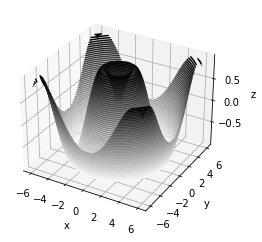

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

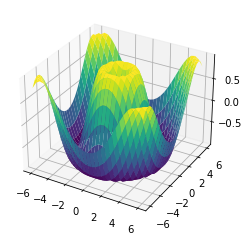

In [9]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

In [14]:
import numpy as np
x_ = np.array([[1,2,3],[4,5,6]])
_x = x_.T
print(_x)
print(x_)
x = np.matmul(_x,x_)
print(x)
w,v = np.linalg.eig(x)

[[1 4]
 [2 5]
 [3 6]]
[[1 2 3]
 [4 5 6]]
[[17 22 27]
 [22 29 36]
 [27 36 45]]


In [15]:
w

array([ 9.04026725e+01,  5.97327474e-01, -4.04484173e-15])

In [16]:
v

array([[-0.42866713, -0.80596391,  0.40824829],
       [-0.56630692, -0.11238241, -0.81649658],
       [-0.7039467 ,  0.58119908,  0.40824829]])

In [17]:
print(x)
np.linalg.inv(x)

[[17 22 27]
 [22 29 36]
 [27 36 45]]


LinAlgError: Singular matrix

In [10]:
import torch
from functorch import vmap
N = 5
def f(x):
    return x ** 2

x = torch.randn(N, requires_grad=True)
y = f(x)
basis_vectors = torch.eye(N)

# Sequential approach
jacobian_rows = [torch.autograd.grad(y, x, v, retain_graph=True)[0]
                 for v in basis_vectors.unbind()]
jacobian = torch.stack(jacobian_rows)

# Using `vmap`, we can vectorize the whole computation, computing the
# Jacobian in a single call to `autograd.grad`.
def get_vjp(v):
    return torch.autograd.grad(y, x, v)[0]

jacobian_vmap = vmap(get_vjp)(basis_vectors)
assert torch.allclose(jacobian_vmap, jacobian)


In [1]:
from functorch import vmap

In [3]:
from functorch import hessian

In [5]:
batch_hessian = vmap(hessian)

In [7]:
import functorch

In [8]:
                     # [D], [D] -> []
batched_dot = functorch.vmap(functorch.vmap(torch.dot))  # [N1, N0, D], [N1, N0, D] -> [N1, N0]
x, y = torch.randn(2, 3, 5), torch.randn(2, 3, 5)
batched_dot(x, y) # tensor of size [2, 3]

tensor([[ 1.4696, -1.2516, -0.3284],
        [ 3.3134,  1.2970, -1.6440]])

In [11]:
torch.dot(x[1][1], y[1][1])

tensor(1.2970)

In [12]:
x[1][1]

tensor([ 0.0678,  0.7170, -0.2483,  1.3951, -0.2144])

In [8]:
import torch
tensor1 = torch.randn(10, 1, 4)
tensor2 = torch.randn(10, 4, 4)
torch.matmul(tensor1, tensor2).size()

torch.Size([10, 1, 4])

In [11]:
tensor1.unsqueeze(3).size()

torch.Size([10, 1, 4, 1])

In [59]:
b_s = 3
al = 4
sl = 5
my_reward = reward(sl, sl, al**2 + al + 1)

def _get_reward(state_action):
        
        state, action = torch.split(state_action, [sl, al], dim=-1)
        pre_psd, bias, value = torch.split(my_reward(state), [al**2, al, 1], dim=-1)
        pre_psd = torch.reshape(pre_psd, (al, al))
        pre_psd_trans = torch.transpose(pre_psd, 0, 1)
        psd = torch.matmul(pre_psd, pre_psd_trans)
        
        a_b = (action - bias).unsqueeze(1)
        print(a_b.size())
        a_b_t = torch.transpose(a_b,0,1)
        print(a_b_t.size())
        print(torch.matmul(torch.matmul(a_b_t,psd),a_b).squeeze(-1).size())
        return value - torch.matmul(torch.matmul(a_b_t,psd),a_b).squeeze(-1)

action = torch.rand((1, al))
state = torch.zeros((1, sl))
sain = torch.cat((state[0], action[0]),dim = 0)
print(_get_reward(sain))

torch.Size([4])
torch.Size([4])
torch.Size([4, 1])
torch.Size([1, 4])
torch.Size([1])
tensor([-0.6278], grad_fn=<SubBackward0>)


In [55]:
newrew = vmap(_get_reward)